## Image Generation with Variational Autoencoders
### TMNIST-Alphabet (94 characters and over 281,000 images)
Use variational autoencoders to generate fake images. Adjust the size of the latent space and change the network architecture to figure out the best combination of them to give the best trade-off between compression and quality.

### Variational Autoencoders

In machine learning, a variational autoencoder (VAE), is an artificial neural network architecture introduced by Diederik P. Kingma and Max Welling, belonging to the families of probabilistic graphical models and variational Bayesian methods.

Variational autoencoders are often associated with the autoencoder model because of its architectural affinity, but with significant differences in the goal and mathematical formulation. Variational autoencoders are probabilistic generative models that require neural networks as only a part of their overall structure, as e.g. in VQ-VAE. The neural network components are typically referred to as the encoder and decoder for the first and second component respectively. The first neural network maps the input variable to a latent space that corresponds to the parameters of a variational distribution. In this way, the encoder can produce multiple different samples that all come from the same distribution. The decoder has the opposite function, which is to map from the latent space to the input space, in order to produce or generate data points. Both networks are typically trained together with the usage of the reparameterization trick, although the variance of the noise model can be learned separately.

Although this type of model was initially designed for unsupervised learning, its effectiveness has been proven for semi-supervised learning and supervised learning.

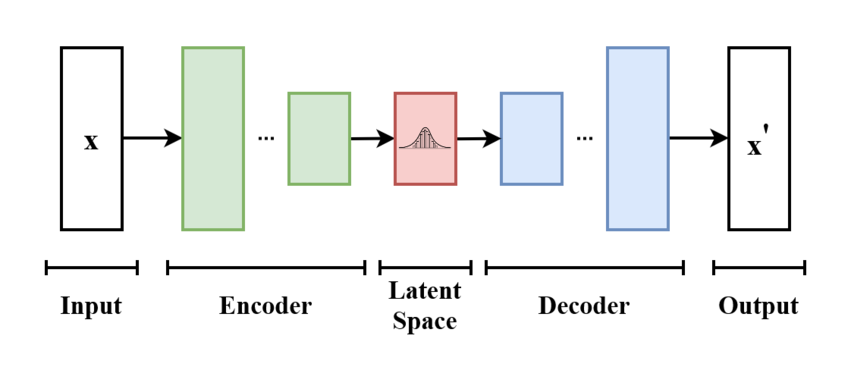

### Architecture

Autoencoders are a type of neural network that learns the data encodings from the dataset in an unsupervised way. It basically contains two parts: the first one is an encoder which is similar to the convolution neural network except for the last layer. The aim of the encoder to learn efficient data encoding from the dataset and pass it into a bottleneck architecture. The other part of the autoencoder is a decoder that uses latent space in the bottleneck layer to regenerate the images similar to the dataset. These results backpropagate from the neural network in the form of the loss function.

Variational autoencoder is different from autoencoder in a way such that it provides a statistic manner for describing the samples of the dataset in latent space. Therefore, in variational autoencoder, the encoder outputs a probability distribution in the bottleneck layer instead of a single output value.

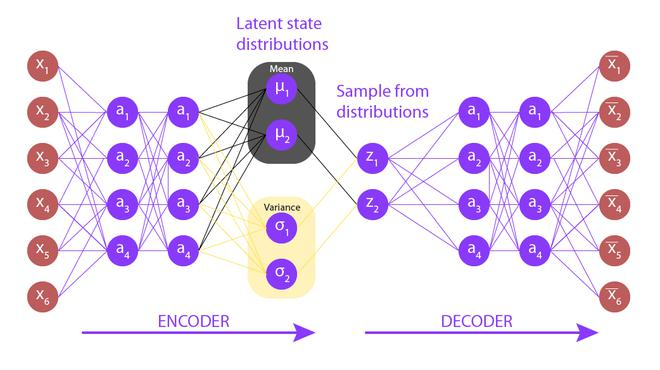
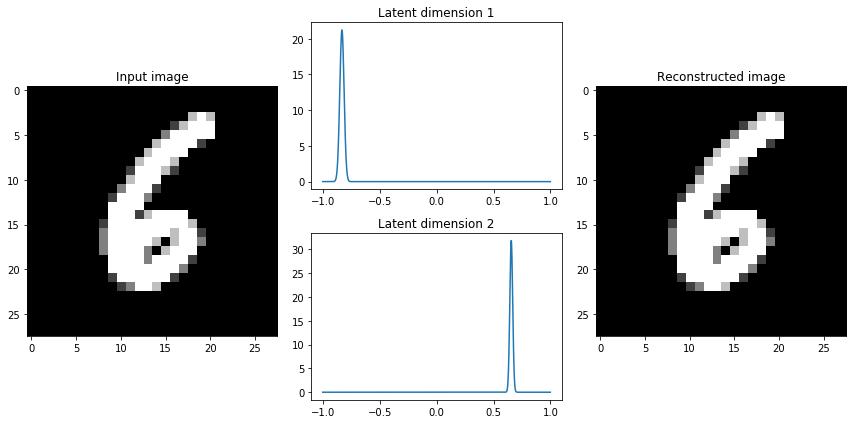

### Implementation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2 # because of z_mean and z_log_variance
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
print(conv_shape)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

(None, 7, 7, 64)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                           

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu")(latent_inputs) # 7x7x64 shape
x = layers.Reshape((conv_shape[1],conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
df = pd.read_csv('94_character_TMNIST.csv')

In [7]:
print(df.shape)
X = df.drop(columns={'names','labels'})

(274093, 786)


In [8]:
X_images = X.values.reshape(-1,28,28)
X_images = np.expand_dims(X_images, -1).astype("float32") / 255

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_images, epochs=10, batch_size=128)

Epoch 1/10
2142/2142 [==============================] - 157s 73ms/step - loss: 192.0563 - reconstruction_loss: 163.0816 - kl_loss: 4.7089
Epoch 2/10
2142/2142 [==============================] - 154s 72ms/step - loss: 155.7257 - reconstruction_loss: 149.6810 - kl_loss: 5.2997
Epoch 3/10
2142/2142 [==============================] - 155s 73ms/step - loss: 152.7875 - reconstruction_loss: 146.8644 - kl_loss: 5.5827
Epoch 4/10
2142/2142 [==============================] - 158s 74ms/step - loss: 151.1191 - reconstruction_loss: 145.0140 - kl_loss: 5.7717
Epoch 5/10
2142/2142 [==============================] - 158s 74ms/step - loss: 149.8330 - reconstruction_loss: 143.7359 - kl_loss: 5.9027
Epoch 6/10
2142/2142 [==============================] - 162s 76ms/step - loss: 148.6745 - reconstruction_loss: 142.6839 - kl_loss: 6.0207
Epoch 7/10
2142/2142 [==============================] - 157s 73ms/step - loss: 147.9846 - reconstruction_loss: 141.8250 - kl_loss: 6.1063
Epoch 8/10
2142/2142 [============

1/1 [==============================] - 0s 16ms/step


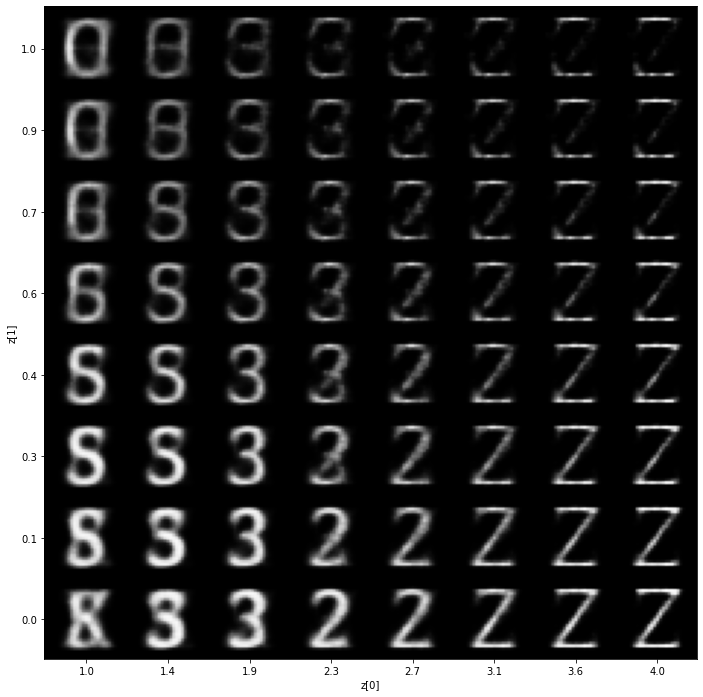

In [12]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=8, figsize=12):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale_x_left = 1 # If we change the range, t generate different image.  
    scale_x_right = 4
    scale_y_bottom = 0
    scale_y_top = 1
    figure = np.zeros((digit_size * n, digit_size * n))
    # If we want to see different x and y range we can change values in grid_x and gird_y. I try x= [-3,-2] and y = [-3,-1] values and m labeled imaged are generated.
    grid_x = np.linspace(scale_x_left, scale_x_right, n)        # -3, -2
    grid_y = np.linspace(scale_y_bottom, scale_y_top, n)[::-1]  # -3, -1 

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

### Conclusion
For Variational Autoencoders, I use latent_dim = 2 and epcho = 10 to generate images. The result of this experiments show that VAE's overall performance was not good enough after the same 10 epochs. This architecture generate really good fake images.

Variational autoencoders (VAE) solve the problem of non-regularized potential Spaces in autoencoders and provide generative capability for the whole space. Encoder output potential vector in AE. The encoder for VAE does not output the vectors in the subspace, but the predefined distributed parameters in the subspace of each input. Then VAE imposes constraints on this potential distribution forcing it to become a normal distribution. This constraint ensures that the potential space is regularized.

After the same 10 epochs, VAE's overall performance was not good enough. But conceptually, its training limit should be more refined than AE.

VAE force the conditions of potential variables into the unit norm. The compressed form is the mean and variance of the potential variables. The underlying variables are smooth and continuous. Random values of potential variables produce meaningful output in the decoder. The input to the decoder is a random value sampled from a Gaussian with the mean and variance of the encoder's output.

### Reference
1.TMNIST-Alphabet   https://www.kaggle.com/datasets/nikbearbrown/tmnist-alphabet-94-characters

2.VAE https://www.geeksforgeeks.org/variational-autoencoders

3.Wikipedia https://en.wikipedia.org/wiki/Variational_autoencoder

### License

Copyright (C) <2022>  Hao Fu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.